In [8]:
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Annotated, List
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
import operator
from langgraph.types import Send

In [4]:
load_dotenv()
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.9,
    max_tokens=2048,
    timeout=None,
    max_retries=2
)

In [6]:
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be "
        "covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


planner = llm.with_structured_output(Sections)

In [ ]:
class State(TypedDict):
    topic: str 
    sections: list[Section]
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str


class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


def orchestrator(state: State):
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name "
                "and description. Include no preamble for each section. Use " 
                "markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name}"  
                f"and description: {state['section'].description}"
            ),
        ]
    )
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""
    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}


def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

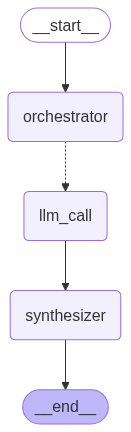

In [10]:
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()


display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [11]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

# Introduction to LLM Scaling Laws

Large Language Models (LLMs) have demonstrated unprecedented capabilities across a wide range of natural language processing tasks. A crucial factor underpinning their rapid advancement is the empirical observation of **LLM scaling laws** [^1]. These laws describe predictable relationships between model performance and key resources invested in their development, primarily computational budget (measured in FLOPs), dataset size, and model parameters. They suggest that, given sufficient data and compute, larger models generally exhibit superior performance and novel emergent abilities.

The **significance** of LLM scaling laws in the context of large language models cannot be overstated. They provide a foundational understanding for the design, training, and deployment of increasingly powerful models. By quantifying the returns on investment in compute, data, and model size, scaling laws offer a roadmap for researchers and engineers, enabling more efficient resource allocation, prediction of future model capabilities, and identification of bottlenecks. They have guided the development of state-of-the-art models by demonstrating that simply scaling up existing architectures often leads to performance gains, sometimes surpassing complex architectural innovations. This understanding has shifted the paradigm of AI research towards exploring the limits of scale.

This report will delve deeper into the various facets of LLM scaling laws. We will begin by exploring the foundational work that established these laws, followed by an analysis of the key parameters and their impact on model performance. Subsequently, the report will discuss the implications of scaling laws for future LLM development, including potential limitations and the emergence of "chinchilla-optimal" training strategies. Finally, we will touch upon the broader societal and ethical considerations arising from the continuous pursuit of larger and more capable models.

[^1]: Kaplan, J., McCandlish, S., Henighan, T., Brown, T.B., Chess, B., Child, R., Chen, S., Radford, A., Sandhini, R., Amodei, D., & Brown, D. (2020). Scaling Laws for Neural Language Models. *arXiv preprint arXiv:2001.08361*.

---

# Fundamental Scaling Principles

Scaling laws describe predictable relationships between model performance and the resources invested in their training. These principles are fundamental to understanding the capabilities and limitations of large language models (LLMs), guiding the efficient allocation of computational resources to achieve desired performance benchmarks. At their core, scaling laws revolve around three primary components: model size, dataset size, and computational budget.

### Core Components of Scaling Laws

1.  **Model Size (Parameters):**
    *   **Description:** Refers to the number of trainable parameters within a neural network. Larger models possess more parameters, theoretically allowing them to learn more complex representations and store more information.
    *   **Impact:** Performance, often measured by loss (e.g., cross-entropy loss), typically improves logarithmically with an increase in model parameters, assuming sufficient data and computation. Larger models are generally more capable but require more memory and computation for training and inference.
    *   **Example:** A model with 100 billion parameters is significantly larger than one with 1 billion parameters.

2.  **Dataset Size (Tokens):**
    *   **Description:** Denotes the total number of tokens (words or sub-word units) in the training corpus. A larger, more diverse, and higher-quality dataset provides more examples for the model to learn from.
    *   **Impact:** Model performance typically improves with an increase in the quantity and quality of training data, often following a power-law relationship. Insufficient data can lead to underfitting, even for large models.
    *   **Example:** Training on 1 trillion tokens versus 100 billion tokens.

3.  **Computational Budget (FLOPs):**
    *   **Description:** Represents the total Floating Point Operations (FLOPs) expended during the training process. This is a direct measure of the computational resources consumed, encompassing both model size and the number of training steps (epochs or iterations).
    *   **Impact:** Performance generally improves with increased computational budget. The optimal allocation of FLOPs across model size and dataset size is a critical aspect of scaling laws.
    *   **Formula:** For transformer models, FLOPs $\approx 6 \times \text{Parameters} \times \text{Tokens}$.

### Prominent Examples of Scaling Laws

The understanding of how these components interact has evolved, leading to significant insights from studies like Kaplan et al. and Hoffmann et al. (Chinchilla).

#### Kaplan Scaling Laws

*   **Study:** "Scaling Laws for Neural Language Models" by Kaplan et al. (2020) from OpenAI.
*   **Key Findings:**
    *   The study systematically explored the independent impact of model size ($N$), dataset size ($D$), and computational budget ($C$) on language model performance (measured by test loss).
    *   They found that performance scales as a power law with each of these factors. Specifically, they observed that loss decreases roughly as $L(N, D, C) \propto N^{-\alpha_N} D^{-\alpha_D} C^{-\alpha_C}$.
    *   A significant finding was the strong dependence on model size, suggesting that larger models were always better, even if trained for fewer steps or on smaller datasets, given a fixed computational budget. This led to the "bigger is better" paradigm where researchers prioritized increasing model parameter count.
    *   **Implication:** This work provided the first comprehensive empirical evidence for predictable scaling behaviors, guiding the design of larger models like GPT-3.

#### Chinchilla Scaling Laws (Hoffmann et al.)

*   **Study:** "Training Compute-Optimal Large Language Models" by Hoffmann et al. (2022) from DeepMind.
*   **Context:** Following the "bigger is better" trend, models like Gopher (DeepMind) and Megatron-Turing NLG (NVIDIA/Microsoft) were developed with hundreds of billions of parameters but were not necessarily compute-optimal.
*   **Key Findings:**
    *   The Chinchilla paper revisited the scaling laws, explicitly focusing on **compute-optimal** training. Instead of varying parameters and data independently, they varied them *while keeping the total computational budget constant*.
    *   They discovered that for a given compute budget, the optimal strategy involves using significantly **smaller models trained on significantly more data** than previously thought (e.g., following the Kaplan regime).
    *   **Optimal Ratio:** For a fixed training FLOPs budget, they found that the number of training tokens should be roughly 20 times the number of model parameters. That is, $D \approx 20N$.
    *   **Example:** If a model has 70 billion parameters, it should ideally be trained on approximately 1.4 trillion tokens for optimal compute efficiency.
    *   **Implication:** This led to the development of the Chinchilla model (70B parameters) which outperformed Gopher (280B parameters) using the same computational budget, demonstrating that efficient scaling is not just about model size but about the balanced allocation of resources between model parameters and training data. This insight has profoundly influenced the training strategies of modern LLMs, including subsequent versions of GPT and other foundation models.

In summary, scaling principles provide a roadmap for efficiently developing more capable LLMs. While initial studies highlighted the power of increasing model size, later research refined this understanding to emphasize the critical importance of balancing model size with the amount of training data for a given computational budget, leading to the development of more compute-optimal and ultimately more efficient large language models.

---

## Empirical Evidence and Key Findings

Empirical research across various machine learning domains, particularly in deep learning, has consistently demonstrated a strong relationship between the scale of a model's components and its ultimate performance. These findings highlight that increasing model parameters, training data, and computational budget typically leads to improved model capabilities, often following predictable patterns known as [scaling laws]{.annotation}.

### Parameters and Performance

*   **Increased Capacity**: Studies have shown that models with more [parameters]{.annotation} (e.g., neurons and weights in a neural network) generally exhibit lower [training loss]{.annotation} and better [generalization performance]{.annotation} on unseen data, provided sufficient training data and compute. Larger models possess a greater capacity to learn complex patterns and store more information.
*   **Examples**: Early work on [Transformer models]{.annotation} for natural language processing (NLP) consistently showed that increasing model size from millions to billions of parameters led to significant reductions in [perplexity]{.annotation} and improved scores on various downstream NLP tasks (e.g., [GLUE benchmark]{.annotation}). The progression from GPT-1 to GPT-3 by OpenAI exemplified this, with GPT-3 (175 billion parameters) significantly outperforming its smaller predecessors.

### Data and Performance

*   **Enhanced Generalization**: Training on larger and more diverse datasets consistently leads to more robust models with improved [generalization abilities]{.annotation}. Even for models of fixed size, increasing the volume and quality of training data can yield substantial performance gains.
*   **Data-Hungry Models**: As models grow in size, their capacity to absorb information increases, making them increasingly [data-hungry]{.annotation}. Large language models, for instance, are trained on hundreds of billions to trillions of tokens.
*   **Examples**: Research on [vision transformers]{.annotation} and other large image models has shown that pre-training on massive image datasets (e.g., [JFT-300M]{.annotation}, [LAION-5B]{.annotation}) leads to superior performance on downstream tasks like [ImageNet classification]{.annotation} and [object detection]{.annotation}, even when compared to models trained on smaller datasets for longer.

### Compute and Performance

*   **Enabling Scale**: The amount of [computational budget]{.annotation} (measured in [FLOPs]{.annotation}, or floating-point operations) directly dictates the feasibility of training larger models on larger datasets for more training steps. More compute allows for exploring larger model architectures and utilizing more extensive data.
*   **Optimizing Training**: For a given model and dataset, increased compute allows for more [training iterations]{.annotation} or more sophisticated [optimization algorithms]{.annotation}, leading to lower final training loss and potentially better performance.
*   **Interdependence**: Compute acts as the primary resource constraint that binds parameters and data. The optimal way to spend a given compute budget often involves a careful balance between model size and the amount of data it is trained on.

### Unifying Scaling Laws and Optimal Allocation

*   **Power-Law Relationships**: Several seminal papers, notably OpenAI's 2020 study on language model scaling, demonstrated that model performance (e.g., test loss) often follows a [power-law relationship]{.annotation} with scale metrics such as the number of parameters, dataset size, and total training compute. This implies predictable improvements with increased scale.
*   **Optimal Scaling (Chinchilla)**: DeepMind's "Chinchilla" paper (2022) provided a critical empirical finding: for a fixed compute budget, there exists an [optimal ratio]{.annotation} between model size and the number of training tokens. They showed that many large language models were "under-trained" for their size, meaning they would have benefited significantly from training on much more data, even if it meant using a slightly smaller model. This re-emphasized the importance of data alongside parameters and compute, suggesting an optimal allocation strategy for resources. For example, Chinchilla (70B parameters) significantly outperformed Gopher (280B parameters) while using 4x fewer parameters and 4x more training data, demonstrating the efficacy of optimal scaling.
*   **Downstream Task Performance**: These empirical findings extend beyond just perplexity or loss. Models trained at larger scales and with optimal resource allocation consistently achieve state-of-the-art results across a wide range of [downstream tasks]{.annotation}, including question answering, summarization, code generation, and complex reasoning benchmarks.

---

## Practical Implications for LLM Development

Understanding the empirical regularities described by LLM scaling laws provides critical guidance for practical decision-making in the development lifecycle, optimizing the often-substantial investments in compute and data.

### Resource Allocation
Scaling laws offer a framework for strategic resource allocation. For instance, the observation that performance often scales more strongly with increased compute and data than with model size (at least for certain ranges and tasks) suggests that simply building larger models without commensurate increases in data or training FLOPs can be inefficient. Instead, resources can be more effectively distributed towards:
*   **Data Acquisition and Quality:** Prioritizing the collection of higher-quality, diverse datasets, as data volume and quality often have a profound impact on model performance, often proportional to N^0.3 to N^0.5.
*   **Compute Budgeting:** Estimating the required compute for a target performance level by leveraging observed power laws (e.g., performance ~ C^-α), allowing for more precise budgeting and hardware procurement. This also informs decisions on whether to pursue larger models or more extensive training with existing model sizes.
*   **Optimal Model-Compute-Data Ratios:** Guides towards finding the "Chinchilla-optimal" configurations, where for a given compute budget, the model size, dataset size, and training steps are balanced to maximize performance. This prevents over-investing in one dimension (e.g., an excessively large model) at the expense of others.

### Model Architecture Design
While scaling laws primarily describe the relationship between resources and performance, they implicitly influence architectural choices by highlighting which aspects of a model are critical for benefiting from increased scale:
*   **Architectural Simplicity and Efficiency:** Architectures that are "scalable" – meaning they can effectively utilize more parameters, data, and compute without collapsing or becoming unstable – are favored. This often translates to simpler, more uniform designs (like the transformer) that exhibit predictable scaling.
*   **Component Prioritization:** Knowing that certain components (e.g., attention mechanisms, feed-forward networks) contribute most to the FLOPs and parameter count in scalable architectures helps in optimizing their implementation for efficiency at scale.
*   **Layer Normalization and Initialization:** The robustness of training large models, crucial for achieving their full potential, is often dependent on stable training dynamics. Scaling laws indirectly emphasize the importance of techniques like proper initialization and normalization schemes that prevent exploding/vanishing gradients as models grow.

### Training Strategies
Scaling laws directly inform critical aspects of the training process itself, aiming to maximize performance given available resources:
*   **Training Schedule Optimization:** If performance scales as a power law with training FLOPs, extending training for longer periods (up to a point of diminishing returns) can be a more efficient path to improved performance than solely increasing model size.
*   **Batch Size Selection:** While not directly a scaling law, understanding how compute scales with performance helps in navigating the trade-offs in batch size. Larger batch sizes can be more compute-efficient per step but may require more steps or different optimizers. Scaling laws help contextualize the overall compute budget.
*   **Hyperparameter Tuning:** While core hyperparameters like learning rate decay schedules are crucial for stable training, scaling laws help identify the primary knobs for performance improvement (model size, data, compute) and guide the focus of hyperparameter optimization towards maximizing the efficiency of resource utilization.
*   **Early Stopping and Evaluation:** Scaling laws predict the general trajectory of performance improvement. This can inform decisions about when to stop training (e.g., if a model has clearly reached a point of strongly diminishing returns relative to its expected scaling behavior) or when to conduct intensive evaluations.

In summary, scaling laws provide an empirical compass for navigating the complex landscape of LLM development, enabling more informed, data-driven decisions that balance performance goals with the practical constraints of computational and data resources.

---

# Challenges and Open Questions

The field of LLM scaling laws, while providing significant insights into model behavior and performance prediction, continues to face substantial challenges and is an active area of ongoing research. Current limitations often center on the practicalities and theoretical completeness of the established power laws.

**Current Limitations and Diminishing Returns:**

*   **Computational and Economic Limits**: While scaling laws suggest continuous performance gains with increased compute, parameters, and data, the practical cost becomes prohibitive. Training state-of-the-art models already requires immense computational resources, leading to questions about the economic viability and environmental sustainability of indefinite scaling. There are concerns about **diminishing returns** where the incremental performance gain per unit of resource investment begins to decrease, particularly for certain tasks or beyond a certain model scale.
*   **Data Scarcity and Quality**: The reliance on vast datasets for scaling is encountering limits. High-quality, diverse, and truly novel data sources are finite. Furthermore, the impact of data quality, curation, and diversity on model performance, beyond simple quantity, is not fully captured by current scaling laws and remains an active area of investigation. Over-reliance on public internet data can also propagate biases and factual inaccuracies.
*   **Theoretical Completeness**: Existing scaling laws primarily focus on loss reduction, which, while correlated with downstream task performance, does not perfectly encapsulate all desirable model behaviors. Complex emergent abilities, reasoning capabilities, and factual accuracy are not always directly predictable from a simple loss curve. The interplay between model architecture, optimization algorithms, and data characteristics is also not fully integrated into a unified theoretical framework.
*   **Generalizability Across Modalities and Architectures**: Most established scaling laws pertain to text-based transformer models. Their direct applicability to multimodal models (e.g., vision-language, audio-language) or novel architectures (e.g., state-space models, mixture-of-experts) is an ongoing research question.

**New Emergent Behaviors and Predictability:**

*   **Unpredictable Emergence**: One of the most fascinating and challenging aspects of LLM scaling is the appearance of **new emergent behaviors** at certain scales, such as in-context learning, chain-of-thought reasoning, and instruction following. These capabilities are not present in smaller models and appear to "switch on" somewhat abruptly. The mechanisms behind these emergences are not well understood or reliably predictable from current scaling laws, making it difficult to engineer models for specific complex abilities.
*   **Beneficial vs. Detrimental Emergence**: While many emergent behaviors are beneficial, others can be problematic, such as increased hallucination rates, biases, or susceptibility to adversarial attacks. Predicting and mitigating these undesirable emergent properties is crucial for safe and reliable AI deployment.

**Open Questions and Future Research Directions:**

*   **Beyond Loss Minimization**: How can scaling laws be extended to predict and optimize for specific, qualitative capabilities (e.g., creativity, common sense reasoning, safety, factuality) rather than just general loss?
*   **The Role of Architectures and Optimization**: To what extent do specific architectural choices (e.g., attention mechanisms, activation functions) and training optimization techniques (e.g., learning rate schedules, regularization) interact with scaling laws, and can these interactions be formalized?
*   **Data-Centric Scaling**: How can we develop scaling laws that more explicitly account for the quality, diversity, and specific properties of data, moving beyond simple data quantity? This includes understanding the impact of pre-training data composition on fine-tuning efficiency and emergent abilities.
*   **Efficiency and Sparse Scaling**: Can we achieve the benefits of large-scale models more efficiently through techniques like sparsity, distillation, or new training paradigms that reduce computational demands without sacrificing performance?
*   **Understanding Mechanisms**: What are the underlying theoretical principles that give rise to scaling laws and emergent behaviors? Developing a deeper mechanistic understanding could lead to more robust prediction and control over model capabilities.
*   **Multi-Modal and Multi-Task Scaling**: How do scaling laws apply when models are trained on diverse data modalities or are expected to perform a wide range of tasks simultaneously? Can we develop unified scaling laws for foundation models that span multiple domains?

---

# Future Directions in Scaling Law Research

Future research in large language model (LLM) scaling laws is poised to expand beyond current paradigms, addressing more complex data modalities, resource efficiency, and the discovery of novel scaling phenomena. These directions are critical for advancing AI capabilities and ensuring sustainable development.

## Multimodal Scaling Laws

Current scaling laws primarily focus on text-based models. A significant future direction involves investigating how performance scales with increased data, model size, and compute across multiple modalities simultaneously. This includes:
*   **Joint Scaling**: Developing frameworks to understand the interdependent scaling of vision, audio, and text data within a single model architecture. This involves defining appropriate units of "multimodal data" and "multimodal compute."
*   **Cross-Modal Transfer**: Examining how scaling in one modality (e.g., visual data) impacts performance in another (e.g., textual understanding related to visual concepts), and whether this transfer exhibits predictable scaling behaviors.
*   **Architectural Implications**: Researching how different multimodal fusion architectures (e.g., early vs. late fusion) influence scaling exponents and overall efficiency.

## Efficient Scaling Techniques

As models continue to grow, the computational and energy costs become prohibitive. Future research will heavily emphasize methods to achieve performance gains more efficiently, rather than solely through brute-force scaling:
*   **Data-Centric Scaling**: Exploring the impact of data quality, diversity, and curation techniques on scaling laws. This includes identifying "high-leverage" data that contributes disproportionately to performance gains, potentially reducing the need for sheer data volume.
*   **Algorithmic Efficiency**: Investigating new optimization algorithms, sparse models, distillation techniques, and parameter-efficient fine-tuning (PEFT) methods that alter the fundamental scaling relationships, achieving better performance with less compute or fewer parameters.
*   **Hardware-Aware Scaling**: Developing scaling laws that explicitly account for hardware advancements and limitations, optimizing model architectures and training strategies for specific compute platforms (e.g., specialized AI accelerators).

## New Scaling Frontiers

The exploration of scaling laws is not limited to performance metrics but extends to emergent capabilities and societal impacts.
*   **Emergent Abilities Scaling**: Quantifying how complex, emergent abilities (e.g., reasoning, code generation, tool use) scale with model size, data, and compute. This involves identifying thresholds and phase transitions where new capabilities appear.
*   **Human-AI Interaction Scaling**: Understanding how the utility and safety of LLMs in human-AI collaborative tasks scale with underlying model improvements. This includes investigating the scaling of alignment, interpretability, and robustness to adversarial attacks.
*   **Beyond Performance Metrics**: Shifting focus from just loss and perplexity to other critical dimensions, such as robustness, fairness, and generalizability across diverse, out-of-distribution tasks, and how these attributes scale.
*   **Theoretical Foundations**: Developing more comprehensive theoretical frameworks that explain *why* scaling laws exist and predict their behavior under novel conditions, moving beyond empirical observations.

---

## Conclusion

Understanding [[Large Language Model (LLM) scaling laws]] has been [[a pivotal breakthrough in artificial intelligence research and development]]. These laws demonstrate a [[predictable and robust relationship between computational resources, data size, and model performance]]. Specifically, they reveal that [[model performance, as measured by perplexity or other metrics, consistently improves as a power law function of compute, data, and model parameters]]. This insight has [[revolutionized the approach to designing and training LLMs]], moving from heuristic-driven methods to a [[scientifically grounded framework]].

The primary impact of scaling laws lies in their [[ability to guide efficient resource allocation and predict future capabilities]]. They have enabled researchers to [[optimize the trade-offs between compute, data, and model size]], leading to [[unprecedented gains in model proficiency and emergent capabilities]]. By providing a [[clear roadmap for performance improvement]], scaling laws have directly contributed to the [[rapid advancement of state-of-the-art LLMs]], such as [[GPT-3, PaLM, and LLaMA]], which exhibit remarkable abilities in [[language understanding, generation, and complex reasoning]]. This predictive power not only [[accelerates research cycles]] but also provides a [[foundation for long-term strategic planning in AI development]]. Ultimately, the insights gleaned from LLM scaling laws are [[indispensable for pushing the boundaries of artificial intelligence]], paving the way for [[even more capable, versatile, and intelligent systems]] in the future.